In [2]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss
from network import exponential_graph, get_alphas
from related_works import colearning, alternating_colearning
from optimization import graph_discovery, regularized_local_FW, local_FW, global_regularized_local_FW, gd_reg_local_FW, centralized_FW
from utils import generate_models, generate_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# set graph of nodes with local personalized data
NB_ITER = 15000
K = 100
D = 20
n = 200
NOISE_R = 0.05
random_state = 2017
MU = 1
BETA = 10

checkevery = 100

V, theta_true, _, angles = generate_models(nb_clust=1, nodes_per_clust=K, inter_clust_stdev=1, random_state=random_state, get_angles=True)
_, X, Y, X_test, Y_test, max_nb_instances = generate_moons(V, theta_true, D, random_state=random_state, sample_error_rate=NOISE_R)

# set graph
nodes, adj_matrix, similarities = exponential_graph(X, Y, X_test, Y_test, V, theta_true, max_nb_instances)

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D+1, min_v=vmin, max_v=vmax)

results = {}

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
}

colors = {
    "Global-Adaboost": "g",
    "Local-Adaboost": "k",
    "Dada-Fixed": "b",
    "Perso-linear-Fixed": "m", 
    "Dada-Learned": "c",    
    "Dada-Random": "r",
}


In [6]:
nodes_copy = deepcopy(nodes)
results["Dada-Fixed"] = regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=MU, monitors=monitors, checkevery=checkevery)

In [7]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=200, monitors={})
results["Global-Adaboost"] = {}
results["Global-Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["Global-Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=200, monitors={})
results["Local-Adaboost"] = {}
results["Local-Adaboost"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["Local-Adaboost"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [12]:
results["Perso-linear-Fixed"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, 
                                similarities, mu=0.1, max_samples_per_node=max_nb_instances, checkevery=checkevery)

In [9]:
from evaluation import kalo_objective

MU, LA = 1, 100
gd_pace = 2000

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
}

gd_nodes = deepcopy(nodes)
results["Dada-Learned"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": gd_pace, 
                    "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=100)

../src/optimization.py:50: RuntimeWarning: divide by zero encountered in log
  return d.dot(l) + (mu / 2) * (w.dot(z) - np.log(d).sum() + la * (mu / 2) * w.dot(w))


# Accuracy and Convergence

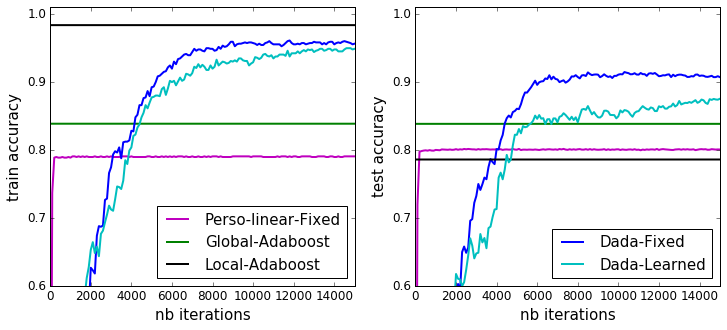

In [14]:
plt.figure(1, figsize=(12, 5))

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('train accuracy', fontsize=15)
plt.xlim(0, max_iter)
plt.ylim(0.6, 1.01)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for k, r_list in results.items():
    label = k
    if k.startswith("Dada"):
        label = '_nolegend_'
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=15)

plt.subplot(122)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('test accuracy', fontsize=15)
plt.xlim(0, max_iter)
plt.ylim(0.6, 1.01)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for k, r_list in results.items():
    label = '_nolegend_'
    if k.startswith("Dada"):
        label = '{}'.format(k)
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=15)

plt.savefig("moons100-acc.pdf", bbox_inches="tight")

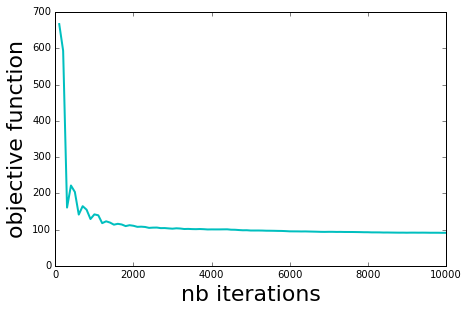

In [15]:
# convergence

max_iter = NB_ITER
plt.figure(1, figsize=(7, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('objective function', fontsize=22)

r_list = results["Dada"]
plt.plot([i*100 for i in range(len(r_list))], [r['obj-function'] for r in r_list], linewidth=2, color='c')

# plt.subplot(212)
# plt.ylim(0, 200)
# plt.xlabel('nb iterations', fontsize=22)
# plt.ylabel('objective function', fontsize=22)

# r_list = results["Dada"]
# plt.plot([i*100 for i in range(len(r_list))], [r['obj-function'] for r in r_list], linewidth=2, color='c')

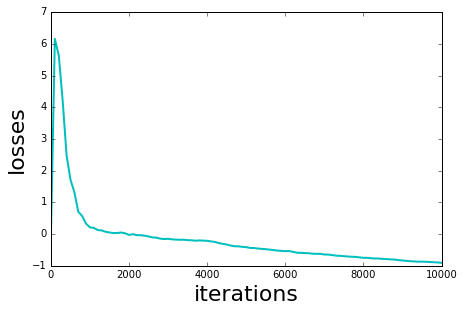

In [16]:
# convergence

max_iter = NB_ITER
plt.figure(1, figsize=(7, 10))

plt.subplot(211)
plt.xlabel('iterations', fontsize=22)
plt.ylabel('losses', fontsize=22)

r_list = results["Dada"]
plt.plot([i*100 for i in range(len(r_list))], [r['loss'] for r in r_list], linewidth=2, color='c')

Dada 35.86


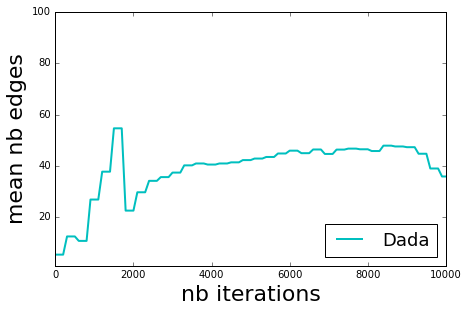

In [17]:
max_iter = NB_ITER

plt.figure(1, figsize=(7, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('mean nb edges', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(1, K)

for k, r_list in results.items():
    try:
        print(k, np.mean(r_list[-1]['edges']))
        plt.plot([i*100 for i in range(len(r_list))], [np.mean(r['edges']) for r in r_list], color='c', label=k, linewidth=2)
    except:
        pass

plt.legend(loc='lower right', fontsize=18)

In [16]:
from scipy.stats import spearmanr

matrix_angles = np.empty((K, K))
for i in range(K):
    for j in range(K):
        matrix_angles[i, j] = abs(angles[i] - angles[j])

In [17]:
def get_edges_weights(adj_matrix, similarities):
    edges = []
    weights = []
    for i in range(K):
        for j in range(i, K):
            if adj_matrix[i, j]:
                edges.append((i, j))
                weights.append(similarities[i, j])
    return edges, weights

In [22]:
import networkx as nx

STEP = gd_pace
kalo_graph = nx.from_numpy_matrix(results["Dada-Learned"][-1]["adj-matrix"])
kalo_edges, kalo_weights = get_edges_weights(results["Dada-Learned"][-1]["adj-matrix"], results["Dada-Learned"][-1]["similarities"])

groundtruth_graph = nx.from_numpy_matrix(adj_matrix)
gr_edges, gr_weights = get_edges_weights(adj_matrix, similarities)

pos_kalo = nx.spring_layout(kalo_graph)
pos = nx.spring_layout(groundtruth_graph)

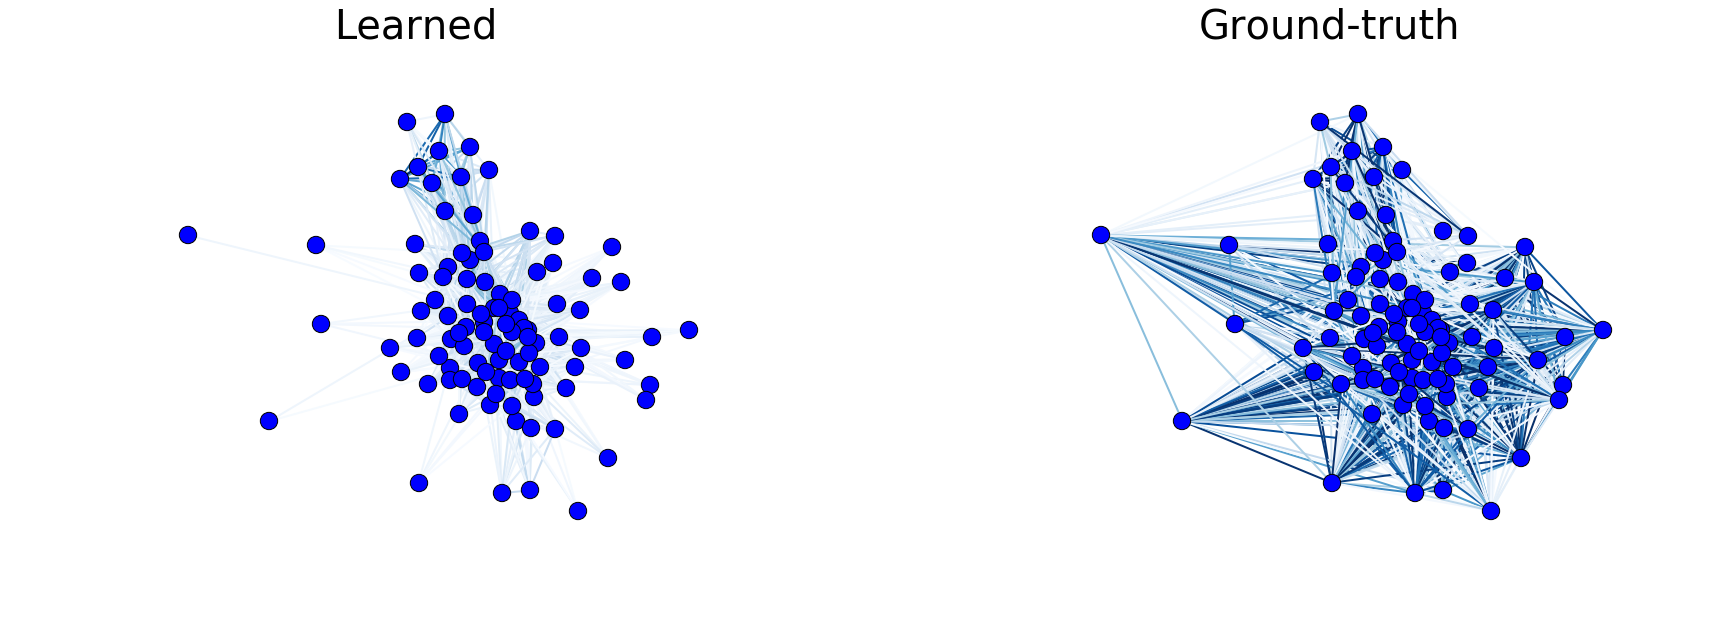

In [37]:
plt.figure(1, figsize=(30, 10))

plt.subplot(121)
plt.title('Learned',fontsize=40)
nx.draw(kalo_graph, pos_kalo, node_color='b', edgelist=kalo_edges, edge_color=kalo_weights, width=2.0, edge_cmap=plt.cm.Blues)

plt.subplot(122)
plt.title('Ground-truth', fontsize=40)
nx.draw(groundtruth_graph, pos_kalo, node_color='b', edgelist=gr_edges, edge_color=gr_weights, width=2.0, edge_cmap=plt.cm.Blues)

plt.savefig("moons100-graphs.pdf", bbox_inches="tight")

In [24]:
import itertools
LA_LIST = [j * 10**i for i in range(-1, 3) for j in range(1, 10, 2)]

results_kalo = {}
# results_kalo = {}.fromkeys(itertools.product(MU_LIST, LA_LIST), {"train-accuracy": [], "test-accuracy": [], "mean-edges": []})
results_kalo = {}.fromkeys(LA_LIST, {"train-accuracy": [], "test-accuracy": [], "mean-edges": []})

NB_ITER = 10000
MU, LA = 1, 100
gd_pace = 2000

for la in LA_LIST:
    
#     for mu in MU_LIST:
    print(la)
    results_kalo[la] = {"train-accuracy": [], "test-accuracy": [], "mean-edges": []}
    
    for _ in range(1):
        gd_nodes = deepcopy(nodes)
        gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": gd_pace, "args":(MU, la)},
                        beta=BETA, mu=MU, nb_iter=NB_ITER, monitors={})

        results_kalo[la]["train-accuracy"].append(central_train_accuracy(gd_nodes))
        results_kalo[la]["test-accuracy"].append(central_test_accuracy(gd_nodes))        
        results_kalo[la]["mean-edges"].append(np.mean(edges(gd_nodes)))

0.1
0.30000000000000004
0.5
0.7000000000000001
0.9
1
3
5
7
9
10
30
50
70
90
100
300
500
700
900


../src/optimization.py:50: RuntimeWarning: divide by zero encountered in log
  return d.dot(l) + (mu / 2) * (w.dot(z) - np.log(d).sum() + la * (mu / 2) * w.dot(w))


In [25]:
# avg results by lambda
keys = []
LA_LIST = [j * 10**i for i in range(-1, 3) for j in range(1, 10, 2)]

for la in LA_LIST:
    try:
        keys += results_kalo[la]["mean-edges"]
    except:
        keys.append(results_kalo[la]["mean-edges"])

keys = set(keys)

# sort results
train = {k: list() for k in keys}
test = {k: list() for k in keys}

for la, value in results_kalo.items():

    for e, tr, te in zip(value["mean-edges"], value["train-accuracy"], value["test-accuracy"]):
        train[e].append(tr)
        test[e].append(te)

sorted_keys = sorted(keys) 

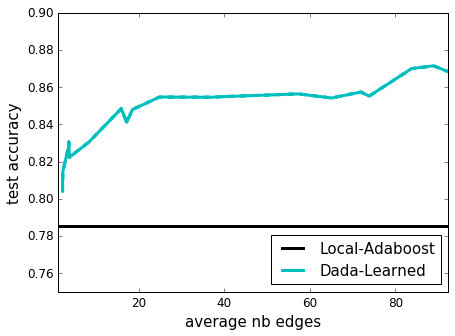

In [35]:
import operator
plt.figure(1, figsize=(7, 5))

plt.xlabel('average nb edges', fontsize=15)
plt.ylabel('test accuracy', fontsize=15)

y = [np.mean(test[k]) for k in sorted_keys]
std = [np.std(test[k]) for k in sorted_keys]
# print(y, sorted_keys)
plt.plot([0, K], [results['Local-Adaboost']['test-accuracy']]*2, label='Local-Adaboost', linewidth=3, color='k')
plt.plot(sorted_keys, y, label='Dada-Learned', linewidth=3, color='c')
plt.plot(sorted_keys, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
plt.plot(sorted_keys, list(map(operator.add, y, std)), '--', linewidth=3, color="c")

plt.xlim(min(sorted_keys), max(sorted_keys))
plt.ylim(0.75, 0.9)
plt.xlim(1, max(sorted_keys))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.legend(loc='lower right', fontsize=15)

plt.savefig("moons100-sparsity.pdf", bbox_inches="tight")

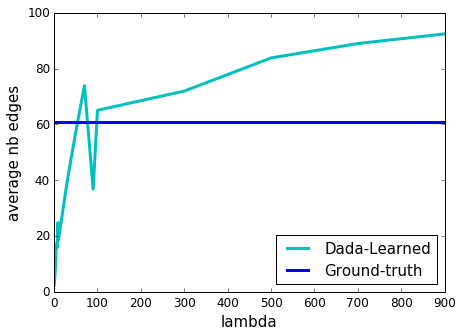

In [29]:
plt.figure(1, figsize=(7, 5))

plt.xlabel('lambda', fontsize=15)
plt.ylabel('average nb edges', fontsize=15)

y = [np.mean(results_kalo[la]["mean-edges"]) for la in LA_LIST]
std = [np.std(results_kalo[la]["mean-edges"]) for la in LA_LIST]
plt.plot(LA_LIST, y, label='Dada-Learned', linewidth=3, color="c")

mean_exp_edges = np.mean(np.sum(adj_matrix, axis=0))
plt.plot([0, max(LA_LIST)], [mean_exp_edges, mean_exp_edges], label='Ground-truth', linewidth=3, color="b")
# plt.plot(LA_LIST, list(map(operator.sub, y, std)), '--', linewidth=3, color="c")
# plt.plot(LA_LIST, list(map(operator.add, y, std)), '--', linewidth=3, color="c")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.legend(loc='lower right', fontsize=15)

plt.savefig("moons100-lambda.pdf", bbox_inches="tight")

In [38]:
print(mean_exp_edges)

60.86
